In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import os
import astropy as ap
from astropy.io import ascii
from astropy.io.ascii import masked
from pylab import *
from astropy import constants as const
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
# import ephem
from astropy.cosmology import FlatLambdaCDM
from matplotlib.ticker import NullFormatter

# Astropy and requests imports
import urllib.parse
from html import unescape
import requests

from astropy.coordinates import SkyCoord

# VO astroquery module
# from navo_utils.registry import Registry
# from navo_utils.image import Image, ImageColumn
# from navo_utils.spectra import Spectra, SpectraColumn
# from navo_utils.cone import Cone
# from navo_utils.tap import Tap
# from navo_utils.utils import astropy_table_from_votable_response

# # Utility functions used in the workshop.
# import workshop_utils.utils

## Suppress unimportant warnings.
import warnings
warnings.filterwarnings("ignore")

Using this 4-class diverging color scheme that's colorblind safe, 
print friendly, and photocopy safe: http://colorbrewer2.org/#type=diverging&scheme=PuOr&n=4

# Constants Used

In [14]:
#---------------------------------------------------------
#Constants, taken from mass_SFR.py done by former students
#---------------------------------------------------------
Mag_sun_w1 = 3.254
Mag_sun_error_w1 = np.sqrt(0.008**2+0.02**2) #extra 0!!
Mag_sun_kt = 3.302
Mag_sun_error_kt = np.sqrt(0.008**2+0.02**2)
lum_sun = 3.828e26 #in W from NASA fact sheet
c = const.c.to('km/s').value #c in km/s
nu_3 = (c*1000)/(11.5608e-6) #in s^-1 from Table 1 in Jarrett et al. (2011) (link: http://iopscience.iop.org/article/10.1088/0004-637X/735/2/112/pdf)
zp_3 = 31.674 #in Jy Table 1 this WISE guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
a_3 = [1.13, 10.24] #Cluver14
a_4 = [0.82, 7.3] #Cluver14
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
h0_error = 2.4 # km/(Mpc*s)
parsec = 3.08567758e16 #m
jansky = 1e-26 #W/m^2/Hz
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# Import/organize catalog from Holwerda et al. (2015)

In [15]:
#Read in the original Holwerda et al. (2015) data set, all pairs
data = pd.read_csv("Data/holwerda15.csv")

#Filter into pair categories: PG+ELG, PG+PG, ELG+PG, ELG+ELG
pg_elg_pairs = data[data["spec_type"] == "PG+ELG"]
pg_pg_pairs = data[data["spec_type"] == "PG+PG"]
elg_pg_pairs = data[data["spec_type"] == "ELG+PG"]
elg_elg_pairs = data[data["spec_type"] == "ELG+ELG"]
# print(pg_elg_pairs)

#Isolate RA, Dec, z1 (lense), z2 (source) by pair categories: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG
# h_pairs = pg_elg_pairs[["ra","dec","z1","z2","spec_type","cataid"]]
# print(h_pairs)

# Import/organize catalog from Ivan Baldry

In [16]:
#Read in the Ivan Baldry's data set, all pairs
data_baldry = pd.read_csv("data/baldry.csv")
#data_baldry.to_csv("data/baldry.csv")
#print(data_baldry)

# #Filter into pair categories: PG+ELG, PG+PG, ELG+PG, ELG+ELG
baldry_pg_elg_pairs = data_baldry[data_baldry["spec_type"] == "PG+ELG"]
baldry_pg_pg_pairs = data_baldry[data_baldry["spec_type"] == "PG+PG"]
baldry_elg_pg_pairs = data_baldry[data_baldry["spec_type"] == "ELG+PG"]
baldry_elg_elg_pairs = data_baldry[data_baldry["spec_type"] == "ELG+ELG"]
# print(baldry_pg_elg_pairs)

#Isolate RA, Dec, z1 (lense), z2 (source) by pair categories: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG
# b_pairs = baldry_pg_elg_pairs[["ra","dec","z1","z2","spec_type","cataid"]]
# b_pairs.cata_id = b_pairs.cata_id.round(0)
# DO NOT UNCOMMENT! all_pairs.to_csv("original_data.csv")
# print(b_pairs)

#Merge h_pairs (Holwerda) and b_pairs (Baldry) PG+ELG
# all_sample_pairs = pd.merge(h_pairs, b_pairs, on="cataid", how="outer")
# DO NOT UNCOMMENT! all_sample_pairs.to_csv("data/sample_pairs_data.csv")
# print(all_sample_pairs)

# Read in new sample from stuff up there ^^ commented out
all_pairs = pd.read_csv("data/sample_pairs_data.csv")
# print(all_pairs)

#Isolate z1 (lense), z2 (source) for PG+ELG pairs
# z1_pg_elg_pairs = all_pairs["z1"]
# z2_pg_elg_pairs = all_pairs["z2"]
# print(z1_pg_elg_pairs)

# Import WISE data

In [17]:
#--------------------------------------------------------------------
# Read in results from all_pairs_targets.tbl upload for entire sample
#--------------------------------------------------------------------
# all_pairs_results = "data/all_wise_results/all_pairs_results.tbl"
# wise_data_all_pairs = ap.io.ascii.read(all_pairs_results, data_start=0, delimiter='|')
# df_all_pairs = wise_data_all_pairs.to_pandas()

# # Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
# df_all_pairs.ra_01 = df_all_pairs.ra_01.round(3)
# all_pairs.ra = all_pairs.ra.round(3)
# df_all_pairs.iscopy = False
# all_pairs.iscopy = False

# # Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
# merged_data_all_pairs = pd.merge(df_all_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
# print(merged_data_all_pairs)
# # merged_data.to_csv('data/merged_data.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
# z1_all_pairs = merged_data_all_pairs.z1
# z2_all_pairs = merged_data_all_pairs.z2
# w1_all_pairs = merged_data_all_pairs.w1mpro
# #print(w1_all_pairs)
# w2_all_pairs = merged_data_all_pairs.w2mpro
# w3_all_pairs = merged_data_all_pairs.w3mpro
# w1flux_all_pairs = merged_data_all_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from pg_elg_pairs_targets.tbl upload, PG+ELG only
#--------------------------------------------------------------------
pg_elg_pairs_results = "data/all_wise_results/pg_elg_results.tbl"
wise_data_pg_elg_pairs = ap.io.ascii.read(pg_elg_pairs_results, data_start=0, delimiter='|')
df_pg_elg_pairs = wise_data_pg_elg_pairs.to_pandas()
# print(df_pg_elg_pairs)

# Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
df_pg_elg_pairs.ra_01 = df_pg_elg_pairs.ra_01.round(3)
all_pairs.ra = all_pairs.ra.round(3)
df_pg_elg_pairs.iscopy = False
all_pairs.iscopy = False

# Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
# merged_data_pg_elg_pairs = pd.merge(df_pg_elg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
# print(merged_data_pg_elg_pairs)
# DO NOT UNCOMMENT! merged_data_pg_elg_pairs.to_csv('merged_data_pg_elg_pairs.csv')  
merged_data_pg_elg_pairs = pd.read_csv("merged_data_pg_elg_pairs.csv")
# print(merged_data_pg_elg_pairs)
z1_pg_elg_pairs = merged_data_pg_elg_pairs.z1
# print(z1_pg_elg_pairs)
z2_pg_elg_pairs = merged_data_pg_elg_pairs.z2
w1_pg_elg_pairs = merged_data_pg_elg_pairs.w1mpro
w2_pg_elg_pairs = merged_data_pg_elg_pairs.w2mpro
w3_pg_elg_pairs = merged_data_pg_elg_pairs.w3mpro
w1flux_pg_elg_pairs = merged_data_pg_elg_pairs.w1flux

#--------------------------------------------------------------------
# Read in results from pg_pg_pairs_targets.tbl upload, PG+PG only
#--------------------------------------------------------------------
# pg_pg_pairs_results = "data/all_wise_results/pg_pg_results.tbl"
# wise_data_pg_pg_pairs = ap.io.ascii.read(pg_pg_pairs_results, data_start=0, delimiter='|')
# df_pg_pg_pairs = wise_data_pg_pg_pairs.to_pandas()

# # Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
# df_pg_pg_pairs.ra_01 = df_pg_pg_pairs.ra_01.round(3)
# all_pairs.ra = all_pairs.ra.round(3)
# df_pg_pg_pairs.iscopy = False
# all_pairs.iscopy = False

# # Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
# merged_data_pg_pg_pairs = pd.merge(df_pg_pg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
# #merged_data_pg_pg_pairs.to_csv('merged_data_pg_pg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
# z1_pg_pg_pairs = merged_data_pg_pg_pairs.z1
# z2_pg_pg_pairs = merged_data_pg_pg_pairs.z2
# w1_pg_pg_pairs = merged_data_pg_pg_pairs.w1mpro
# w2_pg_pg_pairs = merged_data_pg_pg_pairs.w2mpro
# w3_pg_pg_pairs = merged_data_pg_pg_pairs.w3mpro

# cataid=pd.DataFrame(merged_data_all_pairs.cataid)
# #print(cataid)
# w1flux_pg_pg_pairs = merged_data_pg_pg_pairs.w1flux

# #--------------------------------------------------------------------
# # Read in results from elg_pg_pairs_targets.tbl upload, ELG+PG only
# #--------------------------------------------------------------------
# elg_pg_pairs_results = "data/all_wise_results/elg_pg_results.tbl"
# wise_data_elg_pg_pairs = ap.io.ascii.read(elg_pg_pairs_results, data_start=0, delimiter='|')
# df_elg_pg_pairs = wise_data_elg_pg_pairs.to_pandas()

# # Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
# df_elg_pg_pairs.ra_01 = df_elg_pg_pairs.ra_01.round(3)
# all_pairs.ra = all_pairs.ra.round(3)
# df_elg_pg_pairs.iscopy = False
# all_pairs.iscopy = False

# # Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
# merged_data_elg_pg_pairs = pd.merge(df_elg_pg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
# #merged_data_elg_pg_pairs.to_csv('merged_data_elg_pg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
# z1_elg_pg_pairs = merged_data_elg_pg_pairs.z1
# z2_elg_pg_pairs = merged_data_elg_pg_pairs.z2
# w1_elg_pg_pairs = merged_data_elg_pg_pairs.w1mpro
# w2_elg_pg_pairs = merged_data_elg_pg_pairs.w2mpro
# w3_elg_pg_pairs = merged_data_elg_pg_pairs.w3mpro
# w1flux_elg_pg_pairs = merged_data_elg_pg_pairs.w1flux

# #--------------------------------------------------------------------
# # Read in results from elg_elg_pairs_targets.tbl upload, ELG+ELG only
# #--------------------------------------------------------------------
# elg_elg_pairs_results = "data/all_wise_results/elg_elg_results.tbl"
# wise_data_elg_elg_pairs = ap.io.ascii.read(elg_elg_pairs_results, data_start=0, delimiter='|')
# df_elg_elg_pairs = wise_data_elg_elg_pairs.to_pandas()

# # Having to round WISE RA and Holwerda RA to 3 digits to get merge match @ zero data loss
# df_elg_elg_pairs.ra_01 = df_elg_elg_pairs.ra_01.round(3)
# all_pairs.ra = all_pairs.ra.round(3)
# df_elg_elg_pairs.iscopy = False
# all_pairs.iscopy = False

# # Joining on RA since the number of WISE objects < Holwerda et al. (2015) objects
# merged_data_elg_elg_pairs = pd.merge(df_elg_elg_pairs, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')
# #merged_data_elg_elg_pairs.to_csv('merged_data_elg_elg_pairs.csv') #Uncomment this line to visually confirm non-null or non-NaN data (loss) 
# z1_elg_elg_pairs = merged_data_elg_elg_pairs.z1
# z2_elg_elg_pairs = merged_data_elg_elg_pairs.z2
# w1_elg_elg_pairs = merged_data_elg_elg_pairs.w1mpro
# w2_elg_elg_pairs = merged_data_elg_elg_pairs.w2mpro
# w3_elg_elg_pairs = merged_data_elg_elg_pairs.w3mpro
# w1flux_elg_pg_pairs = merged_data_elg_pg_pairs.w1flux

# Calculations

In [18]:
#---------------------------------------------------------------------------------
#c*z1 (lense) Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG
#---------------------------------------------------------------------------------
# cz1_all_pairs = c*z1_all_pairs
cz1_pg_elg_pairs = c*z1_pg_elg_pairs
# cz1_pg_pg_pairs = c*z1_pg_pg_pairs
# cz1_elg_pg_pairs = c*z1_elg_pg_pairs
# cz1_elg_elg_pairs = c*z1_elg_elg_pairs

#---------------------------------------------------------------------------------------------
#Velocity Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in km/s)
#---------------------------------------------------------------------------------------------
# v_all_pairs = c * ((1+z1_all_pairs)**2 - 1)/((1+z1_all_pairs)**2 + 1)
v_pg_elg_pairs = c * ((1+z1_pg_elg_pairs)**2 - 1)/((1+z1_pg_elg_pairs)**2 + 1)
# v_pg_pg_pairs = c * ((1+z1_pg_pg_pairs)**2 - 1)/((1+z1_pg_pg_pairs)**2 + 1)
# v_elg_pg_pairs = c * ((1+z1_elg_pg_pairs)**2 - 1)/((1+z1_elg_pg_pairs)**2 + 1)
# v_elg_elg_pairs = c * ((1+z1_elg_elg_pairs)**2 - 1)/((1+z1_elg_elg_pairs)**2 + 1)

#-------------------------------------------------------------------------------------------
#Distance Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in pc)
#-------------------------------------------------------------------------------------------
# d_all_pairs = (v_all_pairs/h0)*1e6
d_pg_elg_pairs = np.absolute((v_pg_elg_pairs/h0)*1e6)
# d_pg_pg_pairs = (v_pg_pg_pairs/h0)*1e6
# d_elg_pg_pairs = (v_elg_pg_pairs/h0)*1e6
# d_elg_elg_pairs = (v_elg_elg_pairs/h0)*1e6

#-----------------------------------------------------------------------------------------------------
#Absolute Magnitude Calculation (with k correction) by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (mag)
#-----------------------------------------------------------------------------------------------------
# From T. Kettlety et al. (2017), k correction for w1 band is calculated as k = -7.1*log(1+z1), and 
# the distance modulus becomes M = m - 5logd + 5 - k, minus a minus = positive
# AbsMag_all_pairs = w1_all_pairs - 5*np.log10(d_all_pairs) + 5 - 7.1*np.log10(1+z1_all_pairs)#Distance Modulus
AbsMag_pg_elg_pairs = w1_pg_elg_pairs - 5*np.log10(d_pg_elg_pairs) + 5 - 7.1*np.log10(1+z1_pg_elg_pairs)
# AbsMag_pg_pg_pairs = w1_pg_pg_pairs - 5*np.log10(d_pg_pg_pairs) + 5 - 7.1*np.log10(1+z1_pg_pg_pairs)
# AbsMag_elg_pg_pairs = w1_elg_pg_pairs - 5*np.log10(d_elg_pg_pairs) + 5 - 7.1*np.log10(1+z1_elg_pg_pairs)
# AbsMag_elg_elg_pairs = w1_elg_elg_pairs - 5*np.log10(d_elg_elg_pairs) + 5 - 7.1*np.log10(1+z1_elg_elg_pairs)
#print(AbsMag_pg_elg_pairs)
#print(d_pg_elg_pairs)


#-----------------------------------------------------------------------------------------------------
#Luminosity Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in watts)
#-----------------------------------------------------------------------------------------------------
# L_all_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_all_pairs))
L_pg_elg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_pg_elg_pairs))
# L_pg_pg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_pg_pg_pairs))
# L_elg_pg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_elg_pg_pairs))
# L_elg_elg_pairs = 10**(0.4*(Mag_sun_w1 - AbsMag_elg_elg_pairs))

#----------------------------------------------------------------------------------------------------------------
#Stellar Mass Estimate from w1 by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses)
#----------------------------------------------------------------------------------------------------------------
# Mstar_all_pairs = w1_all_pairs * 0.6
# Mstar_pg_elg_pairs = w1_pg_elg_pairs * 0.6
# Mstar_pg_pg_pairs = w1_pg_pg_pairs * 0.6
# Mstar_elg_pg_pairs = w1_elg_pg_pairs * 0.6
# Mstar_elg_elg_pairs = w1_elg_elg_pairs * 0.6
# #print(Mstar_pg_elg_pairs)

# logMstar_est_all_pairs = np.log10(Mstar_all_pairs)

#----------------------------------------------------------------------------------------------------------------
#logMstar Calculation from Cluver et al. (2014) eq. 2 by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses)
#----------------------------------------------------------------------------------------------------------------
# logMstar_all_pairs = -1.96*(w1_all_pairs-w2_all_pairs)-0.03+np.log10(L_all_pairs)
# logMstardf = pd.DataFrame({'logMstarWISE':logMstar_all_pairs.values})
# wise_data_final = pd.merge(cataid, logMstardf, left_index=True, right_index=True)
logMstar_pg_elg_pairs = -1.96*(w1_pg_elg_pairs-w2_pg_elg_pairs)-0.03 +np.log10(L_pg_elg_pairs)
logMstardf = pd.DataFrame({'logMstarWISE':logMstar_pg_elg_pairs.values})
# print(logMstardf)
wise_data_final = pd.merge(merged_data_pg_elg_pairs, logMstardf, left_index=True, right_index=True)
# print(wise_data_final)
# logMstar_pg_pg_pairs = -1.96*(w1_pg_pg_pairs-w2_pg_pg_pairs)-0.03 +np.log10(L_pg_pg_pairs)
# logMstar_elg_pg_pairs = -1.96*(w1_elg_pg_pairs-w2_elg_pg_pairs)-0.03 +np.log10(L_elg_pg_pairs)
# logMstar_elg_elg_pairs = -1.96*(w1_elg_elg_pairs-w2_elg_elg_pairs)-0.03 +np.log10(L_elg_elg_pairs)
#print(logMstar_all_pairs)

#----------------------------------------------------------------------------------------------------------------
#log(Mstar/Lw1) Calculation from Cluver et al. (2014) eq. 2 by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses)
#----------------------------------------------------------------------------------------------------------------
logMstar_Lw1_pg_elg_pairs = logMstar_pg_elg_pairs - np.log10(L_pg_elg_pairs)


#-----------------------------------------------------------------------------------------------------
#Flux Density Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in W/m^2/Hz)
#-----------------------------------------------------------------------------------------------------
# Formula found in Table 1 of this guide: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
# fluxdens_all_pairs = zp_3*10**(-0.4*(w1_all_pairs))*jansky
fluxdens_pg_elg_pairs = zp_3*10**(-0.4*w1_pg_elg_pairs)*jansky
# fluxdens_pg_pg_pairs = zp_3*10**(-0.4*w1_pg_pg_pairs)*jansky
# fluxdens_elg_pg_pairs = zp_3*10**(-0.4*w1_elg_pg_pairs)*jansky
# fluxdens_elg_elg_pairs = zp_3*10**(-0.4*w1_elg_elg_pairs)*jansky

#-----------------------------------------------------------------------------------------------------
#Luminosity Density Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in watts)
#-----------------------------------------------------------------------------------------------------
# lumdens_all_pairs = 4*np.pi*d_all_pairs**2*fluxdens_all_pairs*nu_3
lumdens_pg_elg_pairs = 4*np.pi*d_pg_elg_pairs**2*fluxdens_pg_elg_pairs*nu_3
# lumdens_pg_pg_pairs = 4*np.pi*d_pg_pg_pairs**2*fluxdens_pg_pg_pairs*nu_3
# lumdens_elg_pg_pairs = 4*np.pi*d_elg_pg_pairs**2*fluxdens_elg_pg_pairs*nu_3
# lumdens_elg_elg_pairs = 4*np.pi*d_elg_elg_pairs**2*fluxdens_elg_elg_pairs*nu_3
#print(np.log10(lumdens_pg_elg_pairs))


#-----------------------------------------------------------------------------------------------------
#SFR Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in ??)
#-----------------------------------------------------------------------------------------------------
## NOTE: something wrong with SFR. Narrowed down to lumdens, but not sure if nu or fluxdens is the root cause.
# SFR_all_pairs = 10**((a_3[0])*np.log10(lumdens_all_pairs)-a_3[1])
SFR_pg_elg_pairs = 10**((a_3[0])*np.log10(lumdens_pg_elg_pairs)-a_3[1])
# SFR_pg_pg_pairs = 10**((a_3[0])*np.log10(lumdens_pg_pg_pairs)-a_3[1])
# SFR_elg_pg_pairs = 10**((a_3[0])*np.log10(lumdens_elg_pg_pairs)-a_3[1])
# SFR_elg_elg_pairs = 10**((a_3[0])*np.log10(lumdens_elg_elg_pairs)-a_3[1])
#print(np.log10(SFR_all_pairs))

#-----------------------------------------------------------------------------------------------------
#SFR by Color Estimate ('barbaric') by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in solar masses per year)
#-----------------------------------------------------------------------------------------------------
## NOTE: using this as an approximation for now, until the note above in SFR gets addressed
# SFR_est_all_pairs = w1_all_pairs - w3_all_pairs
SFR_est_pg_elg_pairs = w1_pg_elg_pairs - w3_pg_elg_pairs
# SFR_est_pg_pg_pairs = w1_pg_pg_pairs - w3_pg_pg_pairs
# SFR_est_elg_pg_pairs = w1_elg_pg_pairs - w3_elg_pg_pairs
# SFR_est_elg_elg_pairs = w1_elg_elg_pairs - w3_elg_elg_pairs
#print(np.log10(SFR_est_pg_elg_pairs))

#-----------------------------------------------------------------------------------------------------
#sSFR Calculation by spec. type: all pairs, PG+ELG, PG+PG, ELG+PG, ELG+ELG (units in ??)
#-----------------------------------------------------------------------------------------------------
## NOTE: this is based on estimated SFR per notes above
# sSFR_all_pairs = np.log10(SFR_est_all_pairs) - logMstar_all_pairs
sSFR_pg_elg_pairs = np.log10(SFR_est_pg_elg_pairs) - logMstar_pg_elg_pairs
# sSFR_pg_pg_pairs = np.log10(SFR_est_pg_pg_pairs) - logMstar_pg_pg_pairs
# sSFR_elg_pg_pairs = np.log10(SFR_est_elg_pg_pairs) - logMstar_elg_pg_pairs
# sSFR_elg_elg_pairs = np.log10(SFR_est_elg_elg_pairs) - logMstar_elg_elg_pairs
#print(sSFR_all_pairs)

#-----------------------------------------------------------------------------------------------------
#Einstein Radius Calculation by spec. type for PG+ELG sample
#-----------------------------------------------------------------------------------------------------
f_DM = 10 # dark matter/stars ratio, need to investigate!
DL = cosmo.luminosity_distance(z1_pg_elg_pairs).value/1000 # in Gpc
DS = cosmo.luminosity_distance(z2_pg_elg_pairs).value/1000 # in Gpc
DLS = DS - DL

thetaE = np.sqrt(f_DM*(10**logMstar_pg_elg_pairs)/(10**11.09)) * np.sqrt(DLS/(DL*DS)) # in arcsec

# sample4calcs = pd.read_csv('data/sample_final_no_cuts.csv')
# dl_sample = cosmo.luminosity_distance(sample4calcs.z1).value/1000 # in Gpc
# ds_sample = cosmo.luminosity_distance(sample4calcs.z2).value/1000 # in Gpc
# dls_sample = abs(ds_sample - dl_sample)
# # print(dls_sample)

# thetaEsample = np.sqrt(f_DM*(10**sample4calcs.logMstarWISE)/(10**11.09)) * np.sqrt(dls_sample/(dl_sample*ds_sample)) # in arcsec
# thetaEdf = pd.DataFrame(data=thetaEsample)
# thetaEdf = thetaEdf.rename(columns={'logMstarWISE':'thetaE'})
# final_sample_calcs = sample4calcs.join(thetaEdf)
# # print(final_sample_calcs)
# final_sample_calcs.to_csv("data/final_sample_no_cuts.csv")
# print(np.sqrt(dls_sample/(dl_sample*ds_sample)))

# Import GAMA StellarMasses + Taylor's G23 Supplement

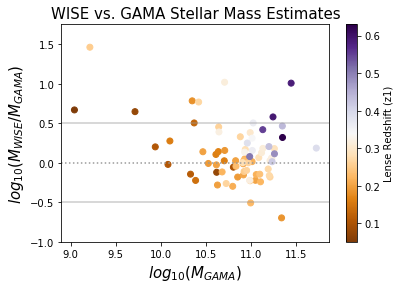

In [19]:
#--------------------------------------------------------------------------------------------------
# Import stellar masses from GAMA DR3 StellarMassesLambdar.fits + Taylor's supplement for G23
#--------------------------------------------------------------------------------------------------
hdul = fits.open('data/StellarMassesLambdar.fits')
gama_data = hdul[1].data
t_hdul = pd.read_table("data/g23_kde_masses.txt", delim_whitespace=True)
# t_hdul.to_csv("data/taylorG23.csv") #Uncomment to write Taylor's G23 data to CSV


# Had to do this for FITS --> DataFrame conversion
gama_cataid = pd.DataFrame(np.array(gama_data["cataid"]).byteswap().newbyteorder())
gama_logMstar = pd.DataFrame(np.array(gama_data["logmstar"]).byteswap().newbyteorder())
gama_z = pd.DataFrame(np.array(gama_data["z"]).byteswap().newbyteorder())
gama_z = gama_z.rename(columns={0:'gama_z'})

# Data merging & management -- getting all GAMA data into one pandas dataframe as "full_gama"
gama_merged_data_A=pd.merge(gama_cataid,gama_logMstar, left_index=True, right_index=True)
gama_merged_data_B=pd.merge(gama_merged_data_A,gama_z, left_index=True, right_index=True)
gama_merged_data_B["0_x"] = gama_merged_data_B["0_x"].astype(int) #Had to typecast to int
gama_merged_data_B.iscopy = False #avoids active override error
gama_merged_data_C = gama_merged_data_B.rename(columns={'0_x':'cataidGAMA','0_y':'logMstarGAMA'})
full_gama = gama_merged_data_C.append(t_hdul)

# Merging WISE and GAMA data into one table called merged_data_final
merged_data_logMstar = pd.merge(wise_data_final, full_gama, how = 'left', left_on = 'cataid', right_on = 'cataidGAMA')
merged_data_final = merged_data_logMstar.rename(columns={'cataid':'cataidWISE'})
# merged_data_final.to_csv("data/merged_data_final.csv") #Uncomment to write merged WISE+GAMA data to CSV

# Calculate WISE logMstar - GAMA logMstar
diffMstar = merged_data_final.logMstarWISE-merged_data_final.logMstarGAMA
# print(len(diffMstar)) #This shows 119 objects in the WISE vs. GAMA plot below, 

#------------------------------------------------------
# Plot the results
#------------------------------------------------------
p = plt.title("WISE vs. GAMA Stellar Mass Estimates",fontsize=15)
p = plt.scatter(merged_data_final.logMstarGAMA,diffMstar,c=z1_pg_elg_pairs, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Lense Redshift (z1)', fontsize=10)
p = plt.ylabel(r'$log_{10}(M_{WISE}/M_{GAMA})$', fontsize=15)
p = plt.xlabel(r'$log_{10}(M_{GAMA})$', fontsize=15)
plt.axhline(y=0.5, color='0.6', alpha=0.5)
plt.axhline(y=0, color='0.6', linestyle=':')
plt.axhline(y=-0.5, color='0.6', alpha=0.5)
plt.ylim((-1,1.75))
# plt.axhspan(-0.5, 0.5, facecolor='green', alpha=0.5)
plt.show()
# plt.savefig('WISE_vs_GAMA_Mstar.png',dpi=150)

# Redshift Profile Histograms

Text(0.5, 0, 'Lense Redshift (z)')

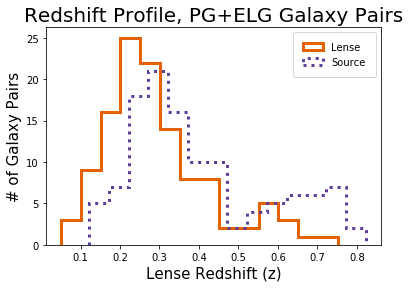

In [20]:
#------------------------------------------------------
#Redshift profile, all galaxy pairs from sample
#------------------------------------------------------
nbins = 30
binwidth = 0.05

# plt.hist(z1_all_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_all_pairs), max(z1_all_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_all_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_all_pairs), max(z2_all_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, All Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel(r'Redshift (z)', fontsize=15)

# plt.show()

#------------------------------------------------------
#Redshift profile, only PG+ELG galaxy pairs from sample
#------------------------------------------------------
plt.hist(z1_pg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_elg_pairs), max(z1_pg_elg_pairs) + binwidth, binwidth), label='Lense')
plt.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
plt.legend(loc='upper right', numpoints=2, borderpad=1)
p = plt.title("Redshift Profile, PG+ELG Galaxy Pairs",fontsize=20)
        
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.ylabel('# of Galaxy Pairs', fontsize=15)
plt.xlabel('Lense Redshift (z)', fontsize=15)

# plt.savefig('PG_ELG_Gals_by_z.png')
# plt.savefig('PG_ELG_Gals_by_z.png', dpi=90, bbox_inches='tight')
# plt.show()

#------------------------------------------------------
#Redshift profile, only PG+PG galaxy pairs from sample
#------------------------------------------------------
# plt.hist(z1_pg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_pg_pairs), max(z1_pg_pg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_pg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_pg_pairs), max(z2_pg_pg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, PG+PG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#------------------------------------------------------
#Redshift profile, only ELG+PG galaxy pairs from sample
#------------------------------------------------------
# plt.hist(z1_elg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_pg_pairs), max(z1_elg_pg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_elg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_pg_pairs), max(z2_elg_pg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, ELG+PG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#-------------------------------------------------------
#Redshift profile, only ELG+ELG galaxy pairs from sample
#-------------------------------------------------------
# plt.hist(z1_elg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_elg_pairs), max(z1_elg_elg_pairs) + binwidth, binwidth), label='Lense')
# plt.hist(z2_elg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_elg_pairs), max(z2_elg_elg_pairs) + binwidth, binwidth), label='Source')
# plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("Redshift Profile, ELG+ELG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('Redshift (z)', fontsize=15)

# plt.show()

#-----------------------------------------------------------
#Subplot for all spec. types: PG+ELG, ELG+PG, PG+PG, ELG+ELG
#-----------------------------------------------------------
# fig = plt.figure()
# fig.suptitle("Galaxy Pair Redshift Profiles by Spec. Type", fontsize=20)

# #PG+ELG Pairs
# ax1 = plt.subplot(221)
# ax1.hist(z1_pg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_elg_pairs), max(z1_pg_elg_pairs) + binwidth, binwidth), label='Lense')
# ax1.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
# ax1.set_title("Redshift Profile, PG+ELG Galaxy Pairs",fontsize=10)

# #ELG+PG Pairs
# ax2 = plt.subplot(222, sharex=ax1, sharey=ax1)
# ax2.hist(z1_elg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_pg_pairs), max(z1_elg_pg_pairs) + binwidth, binwidth), label='Lense')
# ax2.hist(z2_elg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_pg_pairs), max(z2_elg_pg_pairs) + binwidth, binwidth), label='Source')
# ax2.set_title("Redshift Profile, ELG+PG Galaxy Pairs",fontsize=10)
# ax2.legend(loc='upper center', bbox_to_anchor=(1.4, 1.1), numpoints=2, borderpad=1)

# #PG+PG Pairs
# ax3 = plt.subplot(223, sharex=ax1, sharey=ax1)
# ax3.hist(z1_pg_pg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_pg_pg_pairs), max(z1_pg_pg_pairs) + binwidth, binwidth), label='Lense')
# ax3.hist(z2_pg_pg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_pg_pairs), max(z2_pg_pg_pairs) + binwidth, binwidth), label='Source')
# ax3.set_title("Redshift Profile, PG+PG Galaxy Pairs",fontsize=10)

# #ELG+ELG Pairs
# ax4 = plt.subplot(224, sharey=ax1)
# ax4.hist(z1_elg_elg_pairs, histtype='step', linewidth=3, color='#e66101', bins=np.arange(min(z1_elg_elg_pairs), max(z1_elg_elg_pairs) + binwidth, binwidth), label='Lense')
# ax4.hist(z2_elg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_elg_elg_pairs), max(z2_elg_elg_pairs) + binwidth, binwidth), label='Source')
# ax4.set_title("Redshift Profile, ELG+ELG Galaxy Pairs",fontsize=10)

# #Additional subplot configuration
# fig.text(0.5, 0.04, 'Redshift (z)', ha='center', va='center', fontsize=15)
# fig.text(0, 0.5, '# of Galaxy Pairs', ha='center', va='center', rotation='vertical', fontsize=15)
# fig.subplots_adjust(top=0.82, bottom=0.18, left=0.10, right=0.95, hspace=0.95,
#                     wspace=0.35)
# # spaceplots([0,0,0,0], [.02,.02])
# plt.savefig('2by2_Gals_by_z.png', dpi=100, bbox_inches='tight')

# Comparison Plots

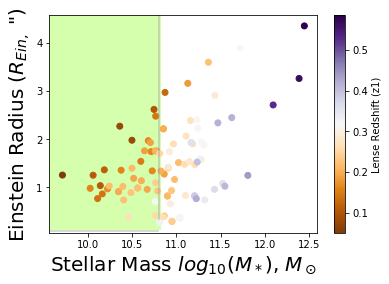

In [70]:
#------------------------------------------------------
# Calculate calibrated apparent magnitude
#------------------------------------------------------
# I was curious what the calibrated magnitude based on flux counts, aperture corrections, and instrumental zero point mags would be...
# See here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html#example
# m_zpt = 20.752
# aper_corr = 0.222 # Found here: http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4c.html#circ
# m_cal = m_zpt - 2.5*log10(w1flux_all_pairs)-aper_corr
#print(m_cal)

#------------------------------------------------------
# Calculate the mean of the raw vs. calibrated diff
#------------------------------------------------------
# meanDiff=mean(abs(m_cal-w1_all_pairs))*100

#------------------------------------------------------
# Plot Mcal vs. Raw w1 mag
#------------------------------------------------------
# plt.title("Calibrated vs. Raw W1 Band Magnitude Comparison",fontsize=15)
# plt.scatter(m_cal,w1_all_pairs,color='#5e3c99')
# m,c=np.polyfit(m_cal,w1_all_pairs,1)
# plt.plot(m_cal,m*m_cal + c, color='#e66101')
# plt.xlabel("Calibrated Magnitude",fontsize=15)
# plt.ylabel("Raw W1 Band Magnitude",fontsize=15)
# plt.text(13.4, 16.35, 'Mean magnitude difference: %d percent' %meanDiff, style='normal', fontsize=12, bbox={'facecolor':'#e66101', 'alpha':1, 'pad':5})
# plt.show()

#------------------------------------------------------
# Plot sSFR vs. Mstar
#------------------------------------------------------
# p = plt.title("WISE sSFR vs. Stellar Mass",fontsize=15)
# p = plt.scatter(logMstar_pg_elg_pairs,sSFR_pg_elg_pairs,c=z1_pg_elg_pairs, cmap=cm.PuOr)
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('Lense Redshift (z1)', fontsize=10)
# p = plt.ylabel(r'$log_{10}(SFR/M*)$', fontsize=15)
# p = plt.xlabel(r'$log_{10}(M*)$', fontsize=15)
# plt.show()

#------------------------------------------------------
# Plot z2 vs. wavelength w/H_alpha 
#------------------------------------------------------

# Plot Halpha line first

# lambdaHalpha = 656.86 # nm
# z = np.arange(0,1,0.1)
# ll = lambdaHalpha*(1+z)
# plt.figure()
# plt.subplot(111)
# plt.title("")
# plt.plot(ll,z,'k-',linewidth=5,label=r'H$\alpha$',alpha=0.7,color='#e66101')


# #Keck broadband filters z and J
# # zbb = np.arange(999,1176,1)
# # Jbb = np.arange(1180,1416,1)
# # plt.fill_between(zbb, 0, 2, facecolor='orange', alpha=0.3)
# # plt.fill_between(Jbb, 0, 2, facecolor='red', alpha=0.3)

# plt.plot(lambdaHalpha*(1+z2_pg_elg_pairs), z2_pg_elg_pairs,'ko',label='Source Galaxies',color='#5e3c99')
# # p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# # p = plt.cbar.set_label('Stellar Mass (M*)', fontsize=10)

# plt.legend()
# plt.tick_params(axis='both', which='major', labelsize=15)
# plt.tick_params(axis='both', which='minor', labelsize=15)

# plt.xlabel(r'Wavelength (nm)', fontsize=20)
# plt.ylabel(r'Source Redshift (z)', fontsize=20)

# # F775W Filter (UVIS)
# plt.text(720,0.38,'F775W', fontsize=15)
# plt.axvspan(680,850, 0.1, 0.4, facecolor='#fdb863', alpha=0.3)

# # F845M Filter (UVIS)
# plt.text(803,0.48,'F845M', fontsize=15)
# plt.axvspan(780,910, 0.2, 0.5, facecolor='#b2abd2', alpha=0.4)

# # F098M Filter (IR)
# plt.text(950,0.77,'F098M', fontsize=15)
# plt.axvspan(890,1100, 0.3, 0.8, facecolor='#fdb863', alpha=0.3)

# # F105W Filter (IR)
# plt.text(1020,0.87,'F105W', fontsize=15)
# plt.axvspan(900,1225, 0.6, 0.9, facecolor='#b2abd2', alpha=0.4)

# plt.show()
# plt.savefig('filter_choice.pdf',bbox_inches='tight')
#plt.savefig('bandwidth_z.png',bbox_inches='tight')

#------------------------------------------------------
# Plot Einstain Radius vs. logMstar, by lense redshift
#------------------------------------------------------

p = plt.scatter(logMstar_pg_elg_pairs, thetaE, c=z1_pg_elg_pairs, cmap=cm.PuOr, zorder=2)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Lense Redshift (z1)', fontsize=10)
plt.axhline(y=0.1, xmax=0.405, color='0.6', alpha=0.5)
# plt.text(9.805,0.04,'HST Ang. Res.')
plt.axvline(x=10.8, ymax=1.4, ymin=0.063, color='0.6', alpha=0.5)
plt.axhline(y=2.35, xmax=0.012, linewidth=215, color='#99ff33', alpha=0.4, zorder=1)


plt.xlabel(r'Stellar Mass $log_{10}(M_*)$, $M_\odot$', fontsize=20)
plt.ylabel(r'Einstein Radius ($R_{Ein,}$ ")', fontsize=20)
# plt.show()
plt.savefig('HST_sm_Theta_E_z_v2.pdf',bbox_inches='tight')

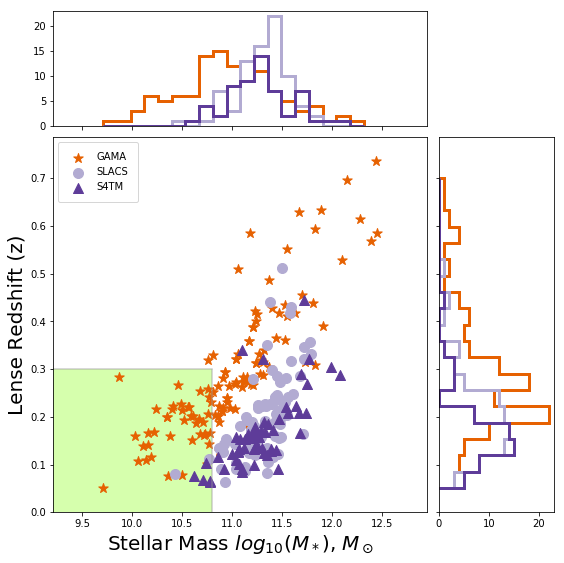

In [36]:
#--------------------------------------------------------------------------------------------------------------------
# Read in/clean data for WISE objects (Holwerda+Baldry with logMstar), SLACS (Auger 2009), SLACS4MASSES (Shu 2015)
#--------------------------------------------------------------------------------------------------------------------
# GAMA, the hard work was done above
# clean_gama = merged_data_final[['logMstarGAMA','gama_z','cataidGAMA']].dropna()
# print(merged_data_final)

# WISE-derived stellar mass data
clean_wise = merged_data_final[['logMstarWISE', 'z1', 'cataidWISE']].dropna()
# print(merged_data_final)

# SLACS, Auger 2009 (found the LaTex file from that paper's Table 4 p. 19)
# slacs = Table.read('data/auger_2009.tex',format='latex')
# dfslacs = slacs.to_pandas()
# print(dfslacs)
# slacs_z = Table.read('data/table_lens_raw.tex',format='latex')
# dfslacs_z = slacs_z.to_pandas()
# print(dfslacs_z)
# dfslacs_z.to_csv('data/slacs_z.csv')
slacs_logMstar = pd.read_csv('data/slacs_logMstar.csv')
slacs_z = pd.read_csv('data/slacs_z.csv')
# dfslacs_logMstar.to_csv('data/slacs_logMstar.csv')
merged_slacs = pd.merge(slacs_logMstar, slacs_z, how = 'left', left_on = 'Name', right_on = 'Name')
clean_slacs = merged_slacs.dropna()

#S4TM, Shu 2015 (email from Benne)
# dfs4tm = pd.read_table("data/S4TM_SMass.txt", delim_whitespace=True)
# dfs4tm.to_csv("data/s4tm.csv")
clean_s4tm = pd.read_csv("data/s4tm.csv")
# print(clean_s4tm)

#------------------------------------------------------
# Plot logMstar vs. z1 for GAMA, SLACS, SLACS4MASSES
#------------------------------------------------------
nullfmt = NullFormatter() # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plots:
axScatter.scatter(clean_wise.logMstarWISE, clean_wise.z1,color='#e66101', marker="*", s=100, linewidth=1, label="GAMA", zorder=2)
axScatter.scatter(clean_slacs.logMstarChab, clean_slacs.z_lens,color='#b2abd2', marker="o", s=100, linewidth=1,label="SLACS", zorder=2)
axScatter.scatter(clean_s4tm.LogSMass_Chab, clean_s4tm.Z_Lens,color='#5e3c99', marker="^", s=100, linewidth=1,label="S4TM", zorder=2)

# print(min(full_gama.logMstarGAMA.dropna()))

# now determine nice limits by hand:
binwidth = 0.5
bins=20
xbins = np.arange(min(clean_wise.logMstarWISE),max(clean_wise.logMstarWISE), (max(clean_wise.logMstarWISE)-min(clean_wise.logMstarWISE))/bins)
ybins = np.arange(min(clean_wise.z1),max(clean_wise.z1), (max(clean_wise.z1)-min(clean_wise.z1))/bins)

axScatter.set_xlim((min(clean_wise.logMstarWISE)-0.5, max(clean_wise.logMstarWISE)+0.5))
axScatter.set_ylim((min(clean_wise.z1)-0.05, max(clean_wise.z1)+0.05))

# GAMA hists
axHistx.hist(clean_wise.logMstarWISE, bins=xbins, histtype='step', linewidth=3, color='#e66101')
axHisty.hist(clean_wise.z1, bins=ybins, orientation='horizontal', histtype='step', linewidth=3, color='#e66101')

# SLACS hists
axHistx.hist(clean_slacs.logMstarChab, bins=xbins, histtype='step', linewidth=3, color='#b2abd2')
axHisty.hist(clean_slacs.z_lens, bins=ybins, orientation='horizontal', histtype='step', linewidth=3, color='#b2abd2')

# S4TM hists
axHistx.hist(clean_s4tm.LogSMass_Chab, bins=xbins, histtype='step', linewidth=3, color='#5e3c99')
axHisty.hist(clean_s4tm.Z_Lens, bins=ybins, orientation='horizontal', histtype='step', linewidth=3, color='#5e3c99')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel(r'Stellar Mass $log_{10}(M_*)$, $M_\odot$', fontsize=20)
axScatter.set_ylabel("Lense Redshift (z)", fontsize=20)
axScatter.legend(loc='upper left', numpoints=2, borderpad=1)

axScatter.axhline(y=0.3, xmax=0.425, color='0.6', alpha=0.5)
axScatter.axvline(x=10.8, ymax=0.38, color='0.6', alpha=0.5)
axScatter.axhline(y=0.15, xmax=0.230, linewidth=145, color='#99ff33', alpha=0.4, zorder=1)

# plt.show()


# plt.title("Stellar Mass $log_{10}(M*)$ vs. Lense Redshift (z1)",fontsize=15)
# # plt.scatter(logMstar_pg_elg_pairs,z1_pg_elg_pairs,color='#e66101', marker="*", label="WISE")
# plt.scatter(gama_data_final.logMstarGAMA, gama_data_final.gama_z,color='#e66101', marker="*", label="GAMA")
# plt.legend()
# plt.show()
plt.savefig('LENSES_mass_z_threeplot.pdf')

In [23]:
# ----------------------------------------------------------------------------------------------------------------------------------
# Fundamental Plane-type plots: GAMA vs. SLACS effective radius, SDSS-i abs. mag, surface brightness-i, env. params, group catalog
#----------------------------------------------------------------------------------------------------------------------------------

# Import SersicCatSDSS.fits, extract GALMUE_r, GALRE_i, GALMAG_i
sersic_dat = Table.read('data/SersicCatSDSS.fits', format='fits')
sersic_df = sersic_dat.to_pandas()
sersic_df.to_csv('data/for_sammy.csv')
clean_sersic = sersic_df[['CATAID', 'GALMUE_r', 'GALRE_i','GALMAG_i']].dropna()
# print(clean_sersic)

# Import EnvironmentMeasures.fits (G15 region only), extract CountInCyl, DistanceTo5nn
envmeas_dat = Table.read('data/EnvironmentMeasures.fits', format='fits')
envmeas_df = envmeas_dat.to_pandas()
clean_envmeas = envmeas_df[['CATAID', 'DistanceTo5nn', 'CountInCyl']].dropna()
# print(clean_envmeas)

# Import GroupFinding.fits (G02, G15 only), extract SepIterCen, SepBCG
groupcat_dat = Table.read('data/G3CGal.fits', format='fits')
groupcat_df = groupcat_dat.to_pandas()
clean_groupcat = groupcat_df[['CATAID', 'AngSepIterCen', 'AngSepBCG']].dropna()
clean_groupcat = clean_groupcat[clean_groupcat.AngSepIterCen != -999.00000]
# print(clean_groupcat)

# Read in our sample, no cuts
sample = pd.read_csv('data/final_sample_no_cuts.csv')
# print(sample)

# GAMA - Join sample with columns from SersicCatSDSS, then that with GroupFinding, then that with EnvironmentMeasures -- inspect for NaNs!
GAMA_merge_sersic = pd.merge(left=sample, right=clean_sersic, on="CATAID", how="inner")
GAMA_merge_groupcat = pd.merge(left=GAMA_merge_sersic, right=clean_groupcat, on="CATAID", how="inner")
GAMA_merge_envmeas = pd.merge(left=GAMA_merge_sersic, right=clean_envmeas, on="CATAID", how="inner")
# print(merge_groupcat)

# SLACS - Join sample with columns from SersicCatSDSS, then that with GroupFinding, then that with EnvironmentMeasures -- inspect for NaNs!
# clean_slacs["CATAID"] = clean_slacs["cataid"].str.upper()
# print(clean_slacs)
# SLACS_merge_sersic = pd.merge(left=clean_slacs, right=clean_sersic, left_on="cataid", right_on="CATAID", how="inner")
# SLACS_merge_groupcat = pd.merge(left=SLACS_merge_sersic, right=clean_groupcat, on="CATAID", how="inner")
# SLACS_merge_envmeas = pd.merge(left=SLACS_merge_sersic, right=clean_envmeas, on="CATAID", how="inner")

# Plot effective radius vs. SDSS-i abs. mag. by 5th nearest neighbor, cylinder density, separation from the group center, and separation from bcg
p = plt.title(r'Effective Radius $r_e$ vs. Abs. Mag. by 5th Nearest Neighbor',fontsize=15)
p = plt.scatter(GAMA_merge_envmeas.GALMAG_i,GAMA_merge_envmeas.GALRE_i,c=GAMA_merge_envmeas.DistanceTo5nn, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Distance to 5th Nearest Neighbor', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'SDSS-i (mag)', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Abs. Mag. by Cylinder Density',fontsize=15)
p = plt.scatter(GAMA_merge_envmeas.GALMAG_i,GAMA_merge_envmeas.GALRE_i,c=GAMA_merge_envmeas.CountInCyl, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Cylinder Density', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'SDSS-i (mag)', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Abs. Mag. by Sep. from Group Center',fontsize=15)
p = plt.scatter(GAMA_merge_groupcat.GALMAG_i,GAMA_merge_groupcat.GALRE_i,c=GAMA_merge_groupcat.AngSepIterCen, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Sep. from Group Center', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'SDSS-i (mag)', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Abs. Mag. by Sep. from BCG',fontsize=15)
p = plt.scatter(GAMA_merge_groupcat.GALMAG_i,GAMA_merge_groupcat.GALRE_i,c=GAMA_merge_groupcat.AngSepBCG, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Sep. from BCG', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'SDSS-i (mag)', fontsize=15)
plt.show()

# Plot effective radius vs. surface brightness by 5th nearest neighbor, cylinder density, separation from the group center, and separation from bcg
p = plt.title(r'Effective Radius $r_e$ vs. Surface Brightness by 5th Nearest Neighbor',fontsize=15)
p = plt.scatter(GAMA_merge_envmeas.GALMUE_r,GAMA_merge_envmeas.GALRE_i,c=GAMA_merge_envmeas.DistanceTo5nn, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Distance to 5th Nearest Neighbor', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'Surface Brightness $\mu_i$', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Surface Brightness by Cylinder Density',fontsize=15)
p = plt.scatter(GAMA_merge_envmeas.GALMUE_r,GAMA_merge_envmeas.GALRE_i,c=GAMA_merge_envmeas.CountInCyl, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Cylinder Density', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'Surface Brightness $\mu_i$', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Surface Brightness by Sep. from Group Center',fontsize=15)
p = plt.scatter(GAMA_merge_groupcat.GALMUE_r,GAMA_merge_groupcat.GALRE_i,c=GAMA_merge_groupcat.AngSepIterCen, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Sep. from Group Center', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'Surface Brightness $\mu_i$', fontsize=15)
plt.show()

p = plt.title(r'Effective Radius $r_e$ vs. Surface Brightness by Sep. from BCG',fontsize=15)
p = plt.scatter(GAMA_merge_groupcat.GALMUE_r,GAMA_merge_groupcat.GALRE_i,c=GAMA_merge_groupcat.AngSepBCG, cmap=cm.PuOr)
p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
p = plt.cbar.set_label('Sep. from BCG', fontsize=10)
p = plt.ylabel(r'Effective Radius $r_e$ (kpc)', fontsize=15)
p = plt.xlabel(r'Surface Brightness $\mu_i$', fontsize=15)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'data/SersicCatSDSS.fits'

# Histograms

In [ ]:
#------------------------------------------------------
#log(M*/Lw1) for PG+ELG galaxy pairs from sample
#------------------------------------------------------
# plt.hist(logMstar_Lw1_pg_elg_pairs,histtype='bar',color='#5e3c99',bins='auto')
# #plt.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
# #plt.legend(loc='upper right', numpoints=2, borderpad=1)
# p = plt.title("$log_{10}(M*/Lw1)$, PG+ELG Galaxy Pairs",fontsize=20)
        
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.tick_params(axis='both', which='minor', labelsize=10)
# plt.ylabel('# of Galaxy Pairs', fontsize=15)
# plt.xlabel('$log_{10}(M*/Lw1)$', fontsize=15)

# # plt.savefig('PG_ELG_Gals_by_z.png')
# #plt.savefig('PG_ELG_Gals_by_z.png', dpi=90, bbox_inches='tight')
# plt.show()

#------------------------------------------------------
#M* for PG+ELG galaxy pairs from sample
#------------------------------------------------------
plt.hist(logMstar_pg_elg_pairs,histtype='bar',color='#5e3c99',bins='auto')
#plt.hist(z2_pg_elg_pairs, histtype='step', linewidth=3, linestyle=':', color='#5e3c99', bins=np.arange(min(z2_pg_elg_pairs), max(z2_pg_elg_pairs) + binwidth, binwidth), label='Source')
#plt.legend(loc='upper right', numpoints=2, borderpad=1)
p = plt.title("$log_{10}(M*)$, PG+ELG Galaxy Pairs",fontsize=20)
        
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.ylabel('# of Galaxy Pairs', fontsize=15)
plt.xlabel('$log_{10}(M*)$', fontsize=15)

# plt.savefig('PG_ELG_Gals_by_z.png')
#plt.savefig('PG_ELG_Gals_by_z.png', dpi=90, bbox_inches='tight')
plt.show()

# 2D Sky Projection

In [ ]:
#----------------------------------------------------------------------
# Holwerda et al. (2015) PG+ELG candidates vs. KiDS, WISE, GAMA Surveys
#----------------------------------------------------------------------

# Read in ascii format, filter by PG+ELG pairs only
holwerda15_all_pairs = ap.io.ascii.read('data/holwerda15.csv')
holwerda15_pg_elg_pairs = holwerda15_all_pairs[holwerda15_all_pairs["spec_type"] == "PG+ELG"]

# Assign RA, Dec with proper units and wrap angle
holwerda15_ra = coord.Angle(holwerda15_pg_elg_pairs["ra"]*u.degree)
holwerda15_ra = holwerda15_ra.wrap_at(180*u.degree)
holwerda15_dec = coord.Angle(holwerda15_pg_elg_pairs["dec"]*u.degree)

# Set up box areas for KiDS North surveys 1 & 2, and KiDS South (Source: https://arxiv.org/pdf/1507.00742.pdf)
kids_n1x = np.array([240*np.pi/180,240*np.pi/180,155*np.pi/180,155*np.pi/180,240*np.pi/180,240*np.pi/180])
kids_n1y = np.array([0,4*np.pi/180,4*np.pi/180,-5*np.pi/180,-5*np.pi/180,0])

kids_n2x = np.array([142*np.pi/180,142*np.pi/180,125*np.pi/180,125*np.pi/180,142*np.pi/180,142*np.pi/180])
kids_n2y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])

kids_sx = np.array([55*np.pi/180,55*np.pi/180,-30*np.pi/180,-30*np.pi/180,55*np.pi/180,55*np.pi/180])
kids_sy = np.array([-30*np.pi/180,-25*np.pi/180,-25*np.pi/180,-35*np.pi/180,-35*np.pi/180,-30*np.pi/180])

# Set up box areas for GAMA survey (http://www.astro.ljmu.ac.uk/~ikb/research/gama_fields/)
gama_02x = np.array([30*np.pi/180,30*np.pi/180,39*np.pi/180,39*np.pi/180,30*np.pi/180,30*np.pi/180])
gama_02y = np.array([-8*np.pi/180,-4*np.pi/180,-4*np.pi/180,-10*np.pi/180,-10*np.pi/180,-8*np.pi/180,])

gama_09x = np.array([128*np.pi/180,128*np.pi/180,142*np.pi/180,142*np.pi/180,128*np.pi/180,128*np.pi/180])
gama_09y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])

gama_12x = np.array([174*np.pi/180,174*np.pi/180,186*np.pi/180,186*np.pi/180,174*np.pi/180,174*np.pi/180])
gama_12y = np.array([0,2*np.pi/180,2*np.pi/180,-3*np.pi/180,-3*np.pi/180,0])

gama_15x = np.array([-149*np.pi/180,-149*np.pi/180,-137*np.pi/180,-137*np.pi/180,-149*np.pi/180,-149*np.pi/180])
gama_15y = np.array([0,3*np.pi/180,3*np.pi/180,-2*np.pi/180,-2*np.pi/180,0])
# print(gama_15y)


gama_23x = np.array([-21*np.pi/180,-21*np.pi/180,-9*np.pi/180,-9*np.pi/180,-21*np.pi/180,-21*np.pi/180])
gama_23y = np.array([-32*np.pi/180,-30*np.pi/180,-30*np.pi/180,-35*np.pi/180,-35*np.pi/180,-32*np.pi/180])

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(holwerda15_ra.radian, holwerda15_dec.radian,color='#000000',s=2)
# ax.set_xticklabels(['23h','21h','19h','17h','15h','13h','11h','9h','7h','5h','3h','1h'])
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)

# Plot KiDS survey areas
ax.plot(kids_n1x,kids_n1y,color='#5e3c99')
ax.plot(kids_n2x,kids_n2y,color='#5e3c99')
ax.plot(kids_sx,kids_sy,color='#5e3c99') #'#e66101'

# Plot GAMA survey areas
ax.plot(gama_02x,gama_02y,color='#e66101',linewidth=1)
# ax.fill(gama_02x,gama_02y,color='green',alpha=0.4)
ax.plot(gama_09x,gama_09y,color='#e66101',linewidth=1)
ax.fill(gama_09x,gama_09y,color='#fdb863',alpha=0.4)
ax.plot(gama_12x,gama_12y,color='#e66101',linewidth=1)
ax.fill(gama_12x,gama_12y,color='#fdb863',alpha=0.4)
ax.plot(gama_15x,gama_15y,color='#e66101',linewidth=1) 
ax.fill(gama_15x,gama_15y,color='#fdb863',alpha=0.4)
ax.plot(gama_23x,gama_23y,color='#e66101',linewidth=1) 

# Plotting the galactic plane (Source: http://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html)

lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
gal_ra = eq_array[:,0]
gal_dec = eq_array[:,1]
x = np.remainder(gal_ra+360-180,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x 
ax.scatter(np.radians(x),np.radians(gal_dec),color="lightgray",marker='p')
# plt.savefig('2D_sky_map.png',dpi=500, transparent=True)

# Old but potentially useful stuff

In [ ]:
# # all_pairs.count()
# # df.count()

# merged_data = pd.merge(df, all_pairs, how = 'left', left_on = 'ra_01', right_on = 'ra')

# # This relation comes from Cluver et al. (2014) p. 7 Eq (2)
# log_Mstar_Lum_W1 = -1.96*(merged_data.w1mpro - merged_data.w2mpro)-0.03

# ## My log(M*) doesn't look right...
# log_Mstar = 10**(-1.96*(merged_data.w1mpro - merged_data.w2mpro) - 0.03 - 0.4*(merged_data.w1mpro-3.24))
# #print(log_Mstar)

# ## Comparing log_Mstar to 0.6*W1...
# #Mstar_from_flux = 0.6*merged_data.w1mpro
# #print(Mstar_from_flux)

# observed_color_W1 = merged_data.w1mpro - merged_data.w2mpro #W1-W2
# observed_color_W3 = merged_data.w2mpro - merged_data.w3mpro #W2-W3

# WISE log(M/L) vs W1-W2, All Pairs (why so linear?)

In [ ]:
# # Plotting all pairs, all redshifts
# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1,observed_color_W1, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
# #p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)

# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# log_Mstar_Lum_W1_lowz = -1.96*(merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro)-0.03
# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.4",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1_lowz,observed_color_W1_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.12

# log_Mstar_Lum_W1_lowestz = -1.96*(merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro)-0.03
# observed_color_W1_lowestz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
# observed_color_W3_lowestz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("WISE Mass-Luminosity vs. Observed Color, z < 0.12",fontsize=15)
# p = plt.scatter(log_Mstar_Lum_W1_lowestz,observed_color_W1_lowestz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# # p = plt.yticks(np.arange(-0.2, 1, step=0.1))
# # p = plt.xticks(np.arange(-1.5, 0.5, step=1))
# p = plt.ylabel(r'$log_{10}(M_*/L_W1)$', fontsize=15)
# p = plt.xlabel(r'W1-W2 (mag)', fontsize=15)

# WISE W1-W2 vs W2-W3, to compare with Cluver et al (2014) Figure 5

In [ ]:
# # Plotting all pairs, all redshifts
# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1, observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)
# #p = plt.scatter(log_Mstar_Lum_W1,observed_color_W3, marker='o', s=30, alpha=0.5, c=merged_data.z1, cmap=cm.PuOr)

    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)

# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.4].w1mpro - merged_data[merged_data.z1 < 0.4].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.4].w2mpro - merged_data[merged_data.z1 < 0.4].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.4].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.4)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)

# # Plotting all pairs where z < 0.4

# observed_color_W1_lowz = merged_data[merged_data.z1 < 0.12].w1mpro - merged_data[merged_data.z1 < 0.12].w2mpro #W1-W2
# observed_color_W3_lowz = merged_data[merged_data.z1 < 0.12].w2mpro - merged_data[merged_data.z1 < 0.12].w3mpro #W2-W3


# plt.figure()
# plt.subplot(111)
# plt.title("W1-W2 vs. W2-W3",fontsize=15)
# p = plt.scatter(observed_color_W1_lowz,observed_color_W3_lowz, s=30, marker='o', alpha=0.5, c=merged_data[merged_data.z1 < 0.12].z1, cmap=cm.PuOr)
    
# p = plt.cbar = plt.colorbar(p, shrink=1, orientation='vertical') #, anchor=(0,1.5))
# p = plt.cbar.set_label('WISE Pairs Lense Redshift (z < 0.12)', fontsize=10)
# p = plt.tick_params(axis='both', which='major', labelsize=15)
# p = plt.tick_params(axis='both', which='minor', labelsize=15)
# p = plt.ylabel(r'W1-W2 (mag)', fontsize=15)
# p = plt.xlabel(r'W2-W3 (mag)', fontsize=15)